In [106]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sompy
from sompy.visualization.mapview import View2D
import matplotlib.pyplot as plt
from hkvportal.io.services import dataportal
import json
import pandas as pd
from io import StringIO
from shapely.geometry import Point
%matplotlib inline

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
file_name = r"D:\Projects\Pr\3537.30\Database\Excel_Database\Database_Totaal.xlsx"

In [67]:
# read all sheets from excel and parse as single dataframe
df = pd.read_excel(file_name, sheetname='Data', ignore_index=False)
#df = pd.concat(df.values())
#df.reset_index(drop=True, inplace=True)

C:\ProgramData\Miniconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [68]:
df.tail()

,Vak_ID,Vaknaam,Omschrijving,Dijkring,Type,HT_Dijkprofiel,HT_Helling binnentalud,HT_Helling buitentalud,PI_Dikte deklaag,PI_Dikte zandlaag 1,...,Pf_Dijken: overloop/golfoverslag (VFM),Pf_Dijken: instabiliteit (VFM),Pf_Dijken: piping (VFM),Pf_Dijken: bekleding (VFM),Pf_Duinen: duinafslag (VFM),Pf_Kunstwerken: overloop/golfoverslag (VFM),Pf_Kunstwerken: niet sluiten (VFM),Pf_Kunstwerken: piping (VFM),Pf_Kunstwerken: constructief falen (VFM),Pf_Vak
3703,87001018,DP18_dp98-dp102,NaN,87,Dijk,37.681,0.30,0,-999.0,-999.0,...,0.003096,0.007238,-999.0,2.507356e-05,-999.0,-999.0,-999.0,-999.0,-999.0,0.007425
3704,87001019,DV19_dp104-dp106,NaN,87,Dijk,37.624,0.36,0,-999.0,-999.0,...,0.003573,-999.000000,-999.0,6.290982e-06,-999.0,-999.0,-999.0,-999.0,-999.0,0.003575
3705,87001020,DV20_dp108-dp112,NaN,87,Dijk,37.538,0.37,0,-999.0,-999.0,...,0.004066,0.018492,-999.0,1.842559e-04,-999.0,-999.0,-999.0,-999.0,-999.0,0.019565
3706,87001021,DV21_dp114-dp120,NaN,87,Dijk,37.696,0.40,0,-999.0,-999.0,...,0.001649,-999.000000,-999.0,2.177418e-06,-999.0,-999.0,-999.0,-999.0,-999.0,0.001650
3707,87001022,DV22_dp122,NaN,87,Dijk,37.882,0.39,0,-999.0,-999.0,...,0.000928,-999.000000,-999.0,1.068515e-07,-999.0,-999.0,-999.0,-999.0,-999.0,0.000928


In [69]:
# deduplicate
df = df[~df.duplicated(subset='Vak_ID', keep='last')]

# get spatial key and filter columns after deduplication
shp_key = df['Vak_ID'].copy()

# exclude some columns
df = df[df.columns.difference(['Vaknaam', 'Omschrijving', 'Type', 'BKL1', 'BKL2', 'Vak_ID'])]
df = df.astype(np.float32)
df.replace(-999., 0., inplace=True)

In [70]:
df.head()

,BKL1_Bewortelingsdiepte,BKL1_Dikte afdeklaag klei,BKL1_Dikte asfaltbeton,BKL1_Steendikte,BKL2_Bewortelingsdiepte,BKL2_Dikte afdeklaag klei,BKL2_Dikte asfaltbeton,BKL2_Steendikte,BSKW_Drempelhoogte kunstwerk,BSKW_Faalkans sluiting,...,Pf_Duinen: duinafslag (VFM),Pf_Kunstwerken: constructief falen,Pf_Kunstwerken: constructief falen (VFM),Pf_Kunstwerken: niet sluiten,Pf_Kunstwerken: niet sluiten (VFM),Pf_Kunstwerken: overloop/golfoverslag,Pf_Kunstwerken: overloop/golfoverslag (VFM),Pf_Kunstwerken: piping,Pf_Kunstwerken: piping (VFM),Pf_Vak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.272301e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272301e-07
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00


In [71]:
# df = df[['m3 aanzanding in duingebied', 'strandbreedte', 'helling buitentalud']]

In [72]:
# drop NaN columns
#df.dropna(axis=1, how='all', inplace=True) #all
X = df.as_matrix()
# format all these values to three decimales

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
df.columns

Index(['BKL1_Bewortelingsdiepte', 'BKL1_Dikte afdeklaag klei',
       'BKL1_Dikte asfaltbeton', 'BKL1_Steendikte', 'BKL2_Bewortelingsdiepte',
       'BKL2_Dikte afdeklaag klei', 'BKL2_Dikte asfaltbeton',
       'BKL2_Steendikte', 'BSKW_Drempelhoogte kunstwerk',
       'BSKW_Faalkans sluiting', 'BSKW_Faalkans van herstel',
       'BSKW_Sluitfrequentie', 'DU_Duinhoogte', 'DU_Korreldiameter duin',
       'Dijkring', 'HTKW_Hoogte kunstwerk', 'HT_Dijkprofiel',
       'HT_Helling binnentalud', 'HT_Helling buitentalud', 'PI_Dikte deklaag',
       'PI_Dikte zandlaag 1', 'PI_Dikte zandlaag 2',
       'PI_Doorlatendheid zandlaag', 'PI_Korreldiameter', 'PI_Kwelslootpeil',
       'PI_Kwelweglengte', 'Pf_Dijken: bekleding',
       'Pf_Dijken: bekleding (VFM)', 'Pf_Dijken: instabiliteit',
       'Pf_Dijken: instabiliteit (VFM)', 'Pf_Dijken: overloop/golfoverslag',
       'Pf_Dijken: overloop/golfoverslag (VFM)', 'Pf_Dijken: piping',
       'Pf_Dijken: piping (VFM)', 'Pf_Duinen: duinafslag',
       '

In [74]:
# train a kohonen network
mapsize = [50, 60]
som = sompy.SOMFactory.build(X, mapsize, mask=None, mapshape='planar', lattice='rect',
                             normalization='var', initialization='pca', neighborhood='gaussian',
                             training='batch', component_names=df.columns, name='sompy')

# verbose='debug' will print more, and verbose=None wont print anything
som.train(n_job=1, verbose='debug')

 Training...
--------------------------------------------------------------
 details: 
      > data len is 3567 and data dimension is 45
      > map size is 50,60
      > array size in log10 scale is 8.68263687783336
      > number of jobs in parallel: 1
 -------------------------------------------------------------

 pca_linear_initialization took: 0.020000 seconds
 Rough training...
 radius_ini: 8.000000 , radius_final: 2.000000, trainlen: 26

 find_bmu took: 0.310000 seconds
 update_codebook_voronoi took: 0.025000 seconds
 epoch: 1 ---> elapsed time:  0.456000, quantization error: 4.260266

 find_bmu took: 0.358000 seconds
 update_codebook_voronoi took: 0.001000 seconds
 epoch: 2 ---> elapsed time:  0.476000, quantization error: 3.427156

 find_bmu took: 0.432000 seconds
 update_codebook_voronoi took: 0.002000 seconds
 epoch: 3 ---> elapsed time:  0.546000, quantization error: 3.074584

 find_bmu took: 0.326000 seconds
 update_codebook_voronoi took: 0.001000 seconds
 epoch: 4 ---> e

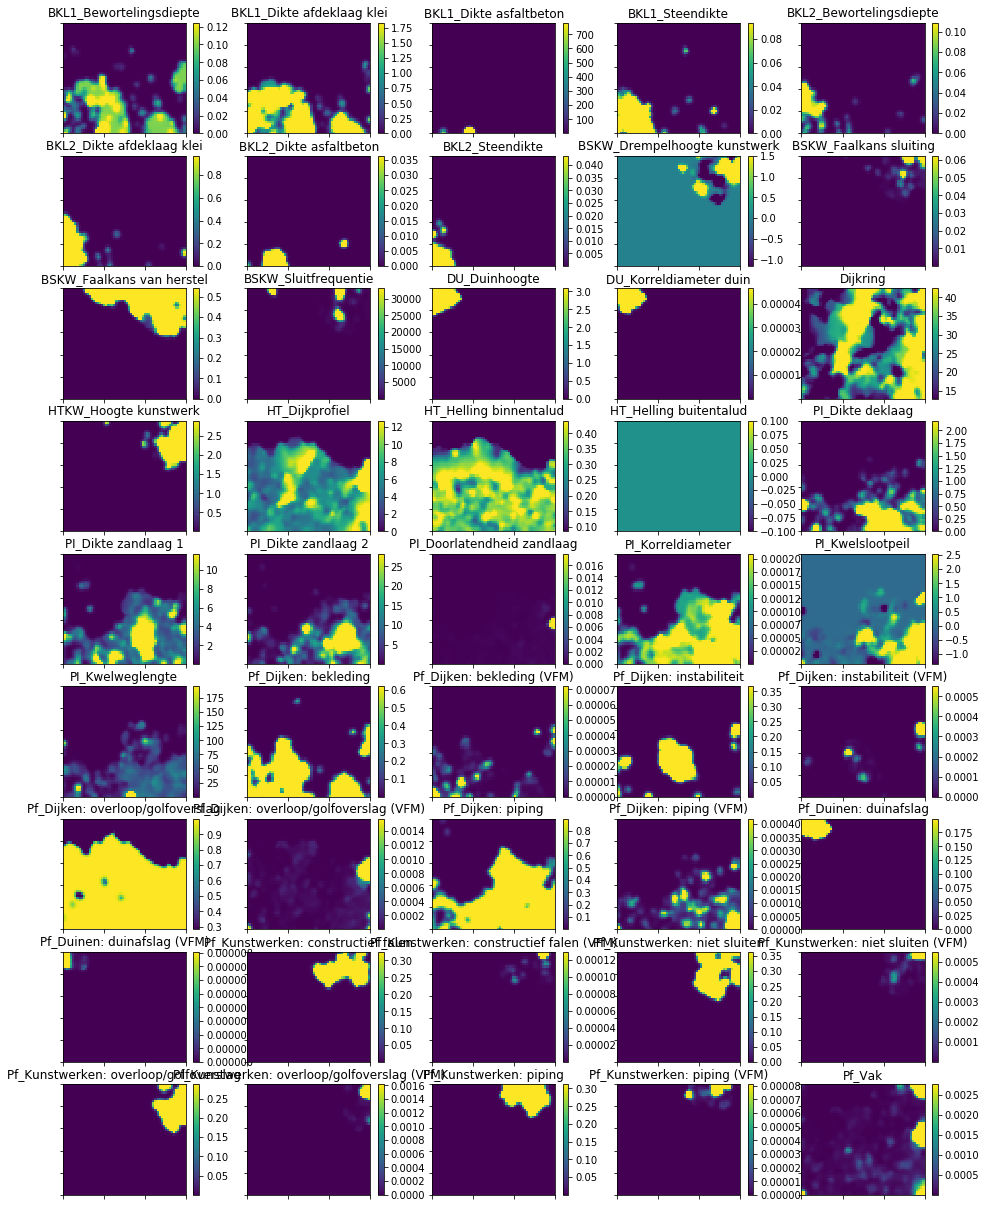

In [75]:
view2D = View2D(25, 25, "rand data", text_size=10)
view2D.show(som, col_sz=5, which_dim="all", denormalize=True)
view2D.save(
    r'D:\Projects\Pr\3537.30\2018-09-11 output/som_codebook_all_paramaters_999_2_zero.png')

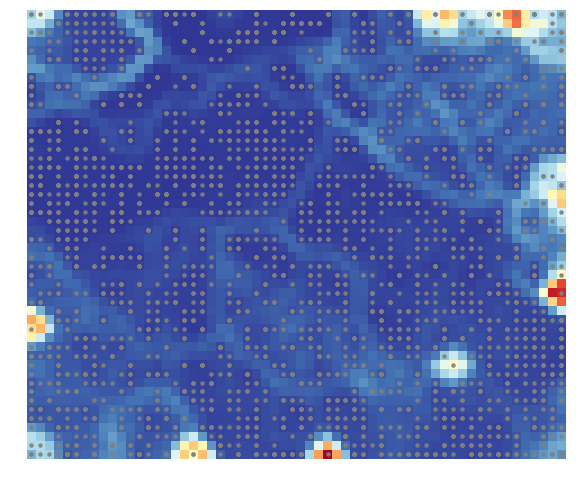

In [76]:
# compute the umatrix
u = sompy.umatrix.UMatrixView(
    50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

# and its values
UMAT = u.build_u_matrix(som, distance=1, row_normalized=False)
UMAT2 = u.show(som, distance2=1, row_normalized=False,
               show_data=True, contooor=False, blob=False)#,
              #filename=r'D:\Projects\Pr\3537.30\2018-09-11 output//u_matrix_all_parameters.png')

In [77]:
# get the coordinates from the derived network (codebook)
codebook = som._normalizer.denormalize_by(som.data_raw, som.codebook.matrix)
msz = som.codebook.mapsize
cents = som.bmu_ind_to_xy(np.arange(0, msz[0] * msz[1]))

yv = cents[:, 0].astype(int)
xv = cents[:, 1].astype(int)
xyv = cents[:, 2].astype(int)  # coordinates

In [78]:
# combine the results from the kohonen network with the original data
df_cb = pd.DataFrame(
    data=codebook, columns=df.columns.str.replace('_', ' '))  # keywords)
df_cb['U-matrix'] = UMAT.flatten('C')
df_cb['X'] = xv
df_cb['Y'] = yv
df_cb['XY'] = xyv

In [79]:
df_cb.head()

,BKL1 Bewortelingsdiepte,BKL1 Dikte afdeklaag klei,BKL1 Dikte asfaltbeton,BKL1 Steendikte,BKL2 Bewortelingsdiepte,BKL2 Dikte afdeklaag klei,BKL2 Dikte asfaltbeton,BKL2 Steendikte,BSKW Drempelhoogte kunstwerk,BSKW Faalkans sluiting,...,Pf Kunstwerken: niet sluiten (VFM),Pf Kunstwerken: overloop/golfoverslag,Pf Kunstwerken: overloop/golfoverslag (VFM),Pf Kunstwerken: piping,Pf Kunstwerken: piping (VFM),Pf Vak,U-matrix,X,Y,XY
0,-1.248726e-08,-3.244629e-07,0.000128,-3.162360e-08,-5.539924e-09,-3.023986e-07,-1.140588e-08,7.192433e-09,-1.286656e-07,2.783410e-08,...,1.281096e-10,9.285730e-08,-4.749789e-10,9.998809e-08,-1.534645e-12,0.000236,5.035255,0,0,0
1,-1.248726e-08,-3.244629e-07,0.000128,-3.162360e-08,-5.539924e-09,-3.023986e-07,-1.140588e-08,7.192433e-09,-1.286656e-07,2.783410e-08,...,1.281096e-10,9.285730e-08,-4.749789e-10,9.998809e-08,-1.534645e-12,0.000187,7.443257,1,0,1
2,-1.248726e-08,-3.244629e-07,0.000128,-3.162360e-08,-5.539924e-09,-3.023986e-07,-1.140588e-08,7.192433e-09,-1.286656e-07,2.783410e-08,...,1.281096e-10,9.285730e-08,-4.749789e-10,9.998809e-08,-1.534645e-12,0.000074,6.517569,2,0,2
3,-1.248726e-08,-3.244629e-07,0.000128,-3.162360e-08,-5.539924e-09,-3.023986e-07,-1.140588e-08,7.192433e-09,-1.286656e-07,2.783410e-08,...,1.281096e-10,9.285730e-08,-4.749789e-10,9.998809e-08,-1.534645e-12,0.000011,2.468176,3,0,3
4,-1.248726e-08,-3.244629e-07,0.000128,-3.162360e-08,-5.539924e-09,-3.023986e-07,-1.140588e-08,7.192433e-09,-1.286656e-07,2.783410e-08,...,1.281096e-10,9.285730e-08,-4.749789e-10,9.998809e-08,-1.534645e-12,0.000002,0.567371,4,0,4


In [80]:
#df.columns = keywords
df['transectnummer'] = shp_key.values.astype(int)
df['som_key'] = som._bmu[0].astype(int)

In [82]:
# get the spatial connection file
shp_file_in = r"D:\Projects\Pr\3537.30\Database\Excel_Database\Database_Totaal.xlsx"
non_gdf = pd.read_excel(shp_file_in, sheet_name='Locaties')

In [87]:
non_gdf = non_gdf[~non_gdf.duplicated(subset='Vak_ID', keep='last')]

In [89]:
rd_string = ("+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 "
             "+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m " 
             "+towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 "
             "+no_defs +no_defs")

In [113]:
# parse to geometry
geometry = [Point(xy) for xy in zip(non_gdf['X-coordinaat'], non_gdf['Y-coordinaat'])]
#df = df.drop(['Lon', 'Lat'], axis=1)
gdf = gpd.GeoDataFrame(non_gdf, crs=rd_string, geometry=geometry)

,Vak_ID,X-coordinaat,Y-coordinaat,geometry
0,1001001,208736.898,611142.598,POINT (208736.898 611142.598)
1,1001002,207828.342,611865.047,POINT (207828.342 611865.047)
2,1001003,207227.178,612248.074,POINT (207227.178 612248.074)
3,1001004,205933.626,612198.195,POINT (205933.626 612198.1949999999)
4,1001005,204950.561,611177.815,POINT (204950.561 611177.8149999999)


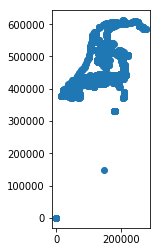

In [114]:
gdf.plot()
gdf.head()

In [115]:
# print and check the coordinate reference system
gdf.crs

'+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 +no_defs +no_defs'

In [116]:
# Let's take a copy of our layer
gdf_proj = gdf.copy()

# Reproject the geometries by replacing the values with projected ones
gdf_proj['geometry'] = gdf_proj['geometry'].to_crs(epsg=4326)

In [119]:
gdf_proj.loc[:, 'Vak_ID'] = gdf_proj.loc[:, 'Vak_ID'].astype(int)
gdf_proj.head()

,Vak_ID,X-coordinaat,Y-coordinaat,geometry
0,1001001,208736.898,611142.598,POINT (6.19666512184254 53.4837384281083)
1,1001002,207828.342,611865.047,POINT (6.183101008048151 53.49032002711937)
2,1001003,207227.178,612248.074,POINT (6.174108087172241 53.4938205901467)
3,1001004,205933.626,612198.195,POINT (6.154612017236035 53.49349811721132)
4,1001005,204950.561,611177.815,POINT (6.139640784626599 53.48442434805879)


In [120]:
# reprojection seems right lets puts back
gdf = gdf_proj

# apply inner join with GeoDataFrame and DataFrame on the transectnummer
gdf_merge_df = gdf.merge(df, left_on='Vak_ID', right_on='transectnummer')

In [121]:
gdf_merge_df.head()

,Vak_ID,X-coordinaat,Y-coordinaat,geometry,BKL1_Bewortelingsdiepte,BKL1_Dikte afdeklaag klei,BKL1_Dikte asfaltbeton,BKL1_Steendikte,BKL2_Bewortelingsdiepte,BKL2_Dikte afdeklaag klei,...,Pf_Kunstwerken: constructief falen (VFM),Pf_Kunstwerken: niet sluiten,Pf_Kunstwerken: niet sluiten (VFM),Pf_Kunstwerken: overloop/golfoverslag,Pf_Kunstwerken: overloop/golfoverslag (VFM),Pf_Kunstwerken: piping,Pf_Kunstwerken: piping (VFM),Pf_Vak,transectnummer,som_key
0,1001001,208736.898,611142.598,POINT (6.19666512184254 53.4837384281083),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1001001,600
1,1001002,207828.342,611865.047,POINT (6.183101008048151 53.49032002711937),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1001002,600
2,1001003,207227.178,612248.074,POINT (6.174108087172241 53.4938205901467),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1001003,601
3,1001004,205933.626,612198.195,POINT (6.154612017236035 53.49349811721132),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272301e-07,1001004,252
4,1001005,204950.561,611177.815,POINT (6.139640784626599 53.48442434805879),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1001005,480


In [122]:
# and select few columns
# gdf_merge_df.head()
gdf_sel = gdf_merge_df.loc[:, ['transectnummer', 'som_key', 'geometry']]

In [123]:
# get the number transects belonging to each nodes in the kohonen network
som_key_all = np.sort(gdf_sel['som_key'].values)
unique, counts = np.unique(som_key_all, return_counts=True)
df_counts = pd.DataFrame(np.array((unique.astype(int), counts)).T, columns=[
                         'som_key_unique', 'number of transects'])

In [124]:
# combine the number of number of transects representing each node to the codebook dataframe
df_cb_counts = pd.merge(df_cb, df_counts, left_on='XY',
                        right_on='som_key_unique', how='left')
df_cb_counts.drop('som_key_unique', axis=1, inplace=True)

# and set format to 3 decimals
integer_columns = ['Vak_ID', 'X', 'Y', 'XY', 'number of transects']
df_cb_counts[df_cb_counts.columns.difference(integer_columns)] = df_cb_counts[df_cb_counts.columns.difference(
    integer_columns)].applymap("{0:.3f}".format)
#df_cb_counts = df_cb_counts.applymap("{0:.3f}".format)

In [126]:
# in the geodataframe we can drop the duplicates avoiding overlap 
gdf_dropdp = gdf_sel.drop_duplicates(subset = ['transectnummer', 'som_key'])

In [127]:
# one final check if all is fine

In [128]:
gdf_dropdp.head()

,transectnummer,som_key,geometry
0,1001001,600,POINT (6.19666512184254 53.4837384281083)
1,1001002,600,POINT (6.183101008048151 53.49032002711937)
2,1001003,601,POINT (6.174108087172241 53.4938205901467)
3,1001004,252,POINT (6.154612017236035 53.49349811721132)
4,1001005,480,POINT (6.139640784626599 53.48442434805879)


In [129]:
df_cb_counts.head()

,BKL1 Bewortelingsdiepte,BKL1 Dikte afdeklaag klei,BKL1 Dikte asfaltbeton,BKL1 Steendikte,BKL2 Bewortelingsdiepte,BKL2 Dikte afdeklaag klei,BKL2 Dikte asfaltbeton,BKL2 Steendikte,BSKW Drempelhoogte kunstwerk,BSKW Faalkans sluiting,...,Pf Kunstwerken: overloop/golfoverslag,Pf Kunstwerken: overloop/golfoverslag (VFM),Pf Kunstwerken: piping,Pf Kunstwerken: piping (VFM),Pf Vak,U-matrix,X,Y,XY,number of transects
0,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,5.035,0,0,0,2.0
1,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,7.443,1,0,1,1.0
2,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,6.518,2,0,2,NaN
3,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,2.468,3,0,3,NaN
4,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,...,0.000,-0.000,0.000,-0.000,0.000,0.567,4,0,4,3.0


In [131]:
# save the spatial GeoDataFrame to a geojson
json_locs_out = r'D:\Projects\Pr\3537.30\2018-09-11 output\transect_locations_all_paramaters_999_2_zero.json'
with open(json_locs_out, 'w') as f:
    f.write(gdf_dropdp.to_json())

# and the codebook DataFrame to a csv
csv_som_out = r'D:\Projects\Pr\3537.30\2018-09-11 output\transect_som_codebook_all_paramaters_999_2_zero.csv'
df_cb_counts.to_csv(csv_som_out, index=False)    

In [132]:
# And store as well in the HKV DATAPORTAL
dp = dataportal()

In [133]:
dp.setDataservice(dataservice='https://dmws.hkvservices.nl/dataportal/')
dp.createDatabase(database='PR3537_30')

Init schema document for None
register_type('{http://www.w3.org/2001/XMLSchema}string', <zeep.xsd.types.builtins.String object at 0x000000001C837CF8>)
register_type('{http://www.w3.org/2001/XMLSchema}boolean', <zeep.xsd.types.builtins.Boolean object at 0x000000001C837BA8>)
register_type('{http://www.w3.org/2001/XMLSchema}decimal', <zeep.xsd.types.builtins.Decimal object at 0x000000001C837C50>)
register_type('{http://www.w3.org/2001/XMLSchema}float', <zeep.xsd.types.builtins.Float object at 0x000000001C837E80>)
register_type('{http://www.w3.org/2001/XMLSchema}double', <zeep.xsd.types.builtins.Double object at 0x000000001C837F60>)
register_type('{http://www.w3.org/2001/XMLSchema}duration', <zeep.xsd.types.builtins.Duration object at 0x000000001C837E48>)
register_type('{http://www.w3.org/2001/XMLSchema}dateTime', <zeep.xsd.types.builtins.DateTime object at 0x000000001C837D30>)
register_type('{http://www.w3.org/2001/XMLSchema}time', <zeep.xsd.types.builtins.Time object at 0x000000001C837E1

dataservice is set. https://dmws.hkvservices.nl/dataportal/ will be used as portal


https://dmws.hkvservices.nl:443 "GET /dataportal/database.asmx/create?database=PR3537_30 HTTP/1.1" 200 77


{'database': 'PR3537_30', 'version': '0.2.0.0', 'date': '2018-11-09 13:06:39'}

### First the GeoJSON

In [134]:
# load the spatial GeoJSON from file
vega_spec = json.load(open(json_locs_out))
# json data uploaden naar data portal
dp.setEntryDatabase(database='PR3537_30', key='VNK_geojson_all_paramaters_999_2_zero',
                    data=json.dumps(vega_spec), description='VNK geojson')

HTTP Post to https://dmws.hkvservices.nl/dataportal/data.asmx:
<?xml version='1.0' encoding='utf-8'?>
<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/"><soap-env:Body><ns0:create xmlns:ns0="http://tempuri.org/"><ns0:database>PR3537_30</ns0:database><ns0:key>VNK_geojson_all_paramaters_999_2_zero</ns0:key><ns0:description>VNK geojson</ns0:description><ns0:data>{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"transectnummer": 1001001, "som_key": 600}, "geometry": {"type": "Point", "coordinates": [6.19666512184254, 53.483738428108296]}}, {"id": "1", "type": "Feature", "properties": {"transectnummer": 1001002, "som_key": 600}, "geometry": {"type": "Point", "coordinates": [6.183101008048151, 53.490320027119374]}}, {"id": "2", "type": "Feature", "properties": {"transectnummer": 1001003, "som_key": 601}, "geometry": {"type": "Point", "coordinates": [6.174108087172241, 53.493820590146704]}}, {"id": "3", "type": "Feature", "pro

{'id': 'c580d67d-1166-43dc-bc46-b20704d2c8f2',
 'key': 'VNK_geojson_all_paramaters_999_2_zero',
 'date': '2018-11-09 13:08:02'}

In [150]:
# load the spatial GeoJSON from file
vega_spec = json.loads(open(r"D:\Projects\Pr\3537.30\2018-09-11 output\nl_rivers2.geojson").read())
# json data uploaden naar data portal
dp.setEntryDatabase(database='PR3537_30', key='VNK_geojson_rivers',
                    data=json.dumps(vega_spec), description='VNK geojson rivers')

HTTP Post to https://dmws.hkvservices.nl/dataportal/data.asmx:
<?xml version='1.0' encoding='utf-8'?>
<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/"><soap-env:Body><ns0:create xmlns:ns0="http://tempuri.org/"><ns0:database>PR3537_30</ns0:database><ns0:key>VNK_geojson_rivers</ns0:key><ns0:description>VNK geojson rivers</ns0:description><ns0:data>{"type": "FeatureCollection", "name": "nl_rivers2", "crs": {"type": "name", "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}}, "features": [{"type": "Feature", "properties": {"dissolve": "150River", "name": "Rhine"}, "geometry": {"type": "MultiLineString", "coordinates": [[[8.229991081646261, 48.96539948124403], [8.262380404562919, 48.98834869999403], [8.283457878521261, 49.00983307499403], [8.356944206646261, 49.10944244999403], [8.361338737896261, 49.11945221561903], [8.380544467062919, 49.2147077494732], [8.387136263937919, 49.23187897343153], [8.397959831646261, 49.2391218119732], [8.410655144146261, 49.2

{'id': '06631d11-6592-48ff-a967-51f8dd979ba2',
 'key': 'VNK_geojson_rivers',
 'date': '2018-11-09 14:03:41'}

### Than the CSV

In [136]:
#output = io.BytesIO()
output = StringIO()
df_cb_counts.to_csv(output, index=False)

In [137]:
dp.setEntryDatabase(database='PR3537_30', key='VNK_csv_all_paramaters_999_2_zero',
                    data=output.getvalue(), description='CSV map VNK')

HTTP Post to https://dmws.hkvservices.nl/dataportal/data.asmx:
<?xml version='1.0' encoding='utf-8'?>
<soap-env:Envelope xmlns:soap-env="http://schemas.xmlsoap.org/soap/envelope/"><soap-env:Body><ns0:create xmlns:ns0="http://tempuri.org/"><ns0:database>PR3537_30</ns0:database><ns0:key>VNK_csv_all_paramaters_999_2_zero</ns0:key><ns0:description>CSV map VNK</ns0:description><ns0:data>BKL1 Bewortelingsdiepte,BKL1 Dikte afdeklaag klei,BKL1 Dikte asfaltbeton,BKL1 Steendikte,BKL2 Bewortelingsdiepte,BKL2 Dikte afdeklaag klei,BKL2 Dikte asfaltbeton,BKL2 Steendikte,BSKW Drempelhoogte kunstwerk,BSKW Faalkans sluiting,BSKW Faalkans van herstel,BSKW Sluitfrequentie,DU Duinhoogte,DU Korreldiameter duin,Dijkring,HTKW Hoogte kunstwerk,HT Dijkprofiel,HT Helling binnentalud,HT Helling buitentalud,PI Dikte deklaag,PI Dikte zandlaag 1,PI Dikte zandlaag 2,PI Doorlatendheid zandlaag,PI Korreldiameter,PI Kwelslootpeil,PI Kwelweglengte,Pf Dijken: bekleding,Pf Dijken: bekleding (VFM),Pf Dijken: instabiliteit,

{'id': '1c399748-1a7b-476c-84e4-55c5846fb62c',
 'key': 'VNK_csv_all_paramaters_999_2_zero',
 'date': '2018-11-09 13:09:05'}

In [138]:
dp.listDatabase(database='PR3537_30')

Starting new HTTPS connection (1): dmws.hkvservices.nl
https://dmws.hkvservices.nl:443 "GET /dataportal/data.asmx/list?database=PR3537_30 HTTP/1.1" 200 309


[{'id': 'c580d67d-1166-43dc-bc46-b20704d2c8f2',
  'key': 'VNK_geojson_all_paramaters_999_2_zero',
  'date': '2018-11-09 13:08:02',
  'description': 'VNK geojson'},
 {'id': '1c399748-1a7b-476c-84e4-55c5846fb62c',
  'key': 'VNK_csv_all_paramaters_999_2_zero',
  'date': '2018-11-09 13:09:05',
  'description': 'CSV map VNK'}]

In [152]:
df_cb_counts.columns.tolist()

['BKL1 Bewortelingsdiepte',
 'BKL1 Dikte afdeklaag klei',
 'BKL1 Dikte asfaltbeton',
 'BKL1 Steendikte',
 'BKL2 Bewortelingsdiepte',
 'BKL2 Dikte afdeklaag klei',
 'BKL2 Dikte asfaltbeton',
 'BKL2 Steendikte',
 'BSKW Drempelhoogte kunstwerk',
 'BSKW Faalkans sluiting',
 'BSKW Faalkans van herstel',
 'BSKW Sluitfrequentie',
 'DU Duinhoogte',
 'DU Korreldiameter duin',
 'Dijkring',
 'HTKW Hoogte kunstwerk',
 'HT Dijkprofiel',
 'HT Helling binnentalud',
 'HT Helling buitentalud',
 'PI Dikte deklaag',
 'PI Dikte zandlaag 1',
 'PI Dikte zandlaag 2',
 'PI Doorlatendheid zandlaag',
 'PI Korreldiameter',
 'PI Kwelslootpeil',
 'PI Kwelweglengte',
 'Pf Dijken: bekleding',
 'Pf Dijken: bekleding (VFM)',
 'Pf Dijken: instabiliteit',
 'Pf Dijken: instabiliteit (VFM)',
 'Pf Dijken: overloop/golfoverslag',
 'Pf Dijken: overloop/golfoverslag (VFM)',
 'Pf Dijken: piping',
 'Pf Dijken: piping (VFM)',
 'Pf Duinen: duinafslag',
 'Pf Duinen: duinafslag (VFM)',
 'Pf Kunstwerken: constructief falen',
 'Pf Ku